# Music Recommendation System

In [1]:
!pip install scikit-surprise

In [2]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from surprise import Dataset, Reader
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import pearsonr
import seaborn as sns
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic

**Loading the dataset and imports.**

Taste Profile Subset reference: http://millionsongdataset.com/tasteprofile/


The Taste profile Subset dataset was downloaded from: 

http://millionsongdataset.com/sites/default/files/challenge/train_triplets.txt.zip

http://millionsongdataset.com/sites/default/files/AdditionalFiles/unique_tracks.txt

In [3]:
songs = pd.read_csv("train_triplets.txt", sep="\t", nrows=10000, names=['user', 'song', 'play_count'], header=None)

In [4]:
songs.head()

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [5]:
file_path = 'unique_tracks.txt'

track_ids = []
song_ids = []
artist_names = []
song_titles = []

with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split('<SEP>')
        
        track_ids.append(parts[0].strip())
        song_ids.append(parts[1].strip())
        artist_names.append(parts[2].strip())
        song_titles.append(parts[3].strip())

tracks = pd.DataFrame({
    'track_id': track_ids,
    'song': song_ids,
    'artist_name': artist_names,
    'song_title': song_titles
})

In [6]:
tracks.head()

,track_id,song,artist_name,song_title
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


Merge both songs and tracks dataframe

In [7]:
df_merged = pd.merge(songs, tracks, how='inner', on='song')
print(df_merged.head())

                                       user                song  play_count  \
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAKIMP12A8C130995           1   
1  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAPDEY12A81C210A9           1   
2  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBBMDR12A8C13253B           2   
3  930d2be6c85315d72cab9823ec0f7bfe7e477794  SOBBMDR12A8C13253B           1   
4  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBFNSP12AF72A0E22           1   

             track_id    artist_name             song_title  
0  TRIQAUQ128F42435AD   Jack Johnson               The Cove  
1  TRIRLYL128F42539D1  Billy Preston   Nothing from Nothing  
2  TRMHBXZ128F4238406  Paco De Lucia        Entre Dos Aguas  
3  TRMHBXZ128F4238406  Paco De Lucia        Entre Dos Aguas  
4  TRYQMNI128F147C1C7     Josh Rouse  Under Cold Blue Stars  


**2. Understanding the data by viewing a few observations**

In [8]:
print(df_merged.shape)

(10270, 6)


In [9]:
songs = df_merged

**2.1 Checking for unique rows and duplicates in the dataset.**

In [10]:
unique_rows = df_merged.drop_duplicates().shape[0]
# Checking for uniques column wise.
print("Number of unique rows:", unique_rows)

Number of unique rows: 10270


In [11]:
# Checking for duplicates column wise.
duplicates = df_merged.duplicated()
print("Duplicates in the dataset:")
print(df_merged[duplicates])

Duplicates in the dataset:
Empty DataFrame
Columns: [user, song, play_count, track_id, artist_name, song_title]
Index: []


**2.2 Finding the range and min-max of the play_count column.**

In [12]:
print("Max value in play_counts column: {}".format(df_merged['play_count'].max()))
print("Min value in play_counts column: {}".format(df_merged['play_count'].min()))

Max value in play_counts column: 140
Min value in play_counts column: 1


In [13]:
print("Play Counts are in the range of: {} - {}".format(df_merged['play_count'].min(), df_merged['play_count'].max()))

Play Counts are in the range of: 1 - 140


**2.3 Visualizing the play_count column's distribution.**

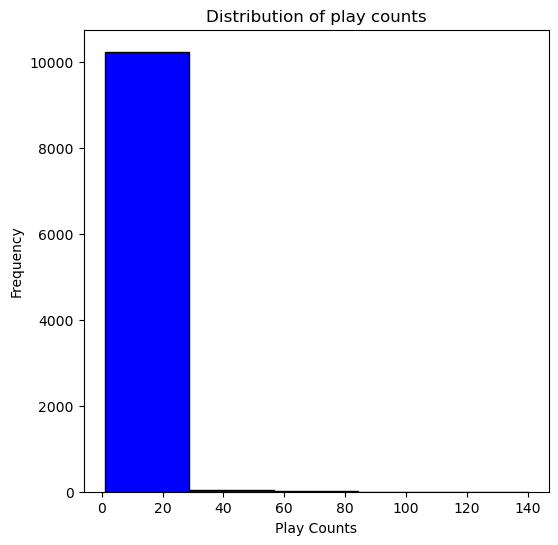

In [14]:
# Plotting the distribution
plt.figure(figsize=(6, 6))
plt.hist(df_merged['play_count'], bins=5, color='blue', edgecolor='black')
plt.title(f'Distribution of play counts')
plt.xlabel('Play Counts')
plt.ylabel('Frequency')
plt.show()

**2.4 Get statistics of the top 10 most played songs and artists**

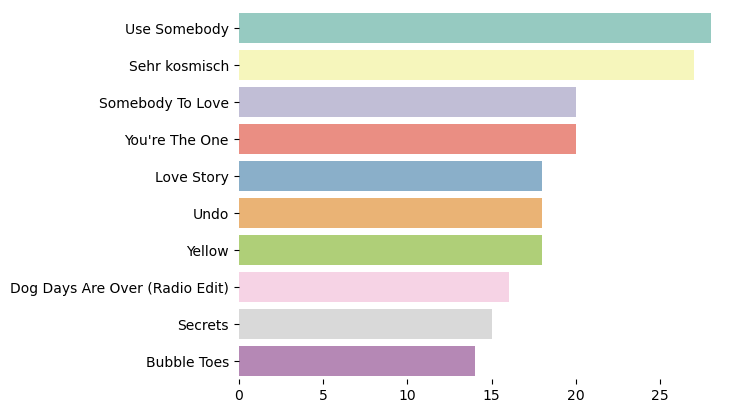

In [15]:
tenSongs = df_merged.groupby('song_title')['play_count'].count().reset_index().sort_values(['play_count', 'song_title'], ascending=[0, 1])
tenSongs['percentage'] = round(tenSongs['play_count'] / tenSongs['play_count'].sum() * 100, 2)
tenSongs = tenSongs[:10]

labels = tenSongs['song_title'].tolist()
counts = tenSongs['play_count'].tolist()

plt.figure()
sns.barplot(x=counts, y=labels, palette='Set3')
sns.despine(left=True, bottom=True)

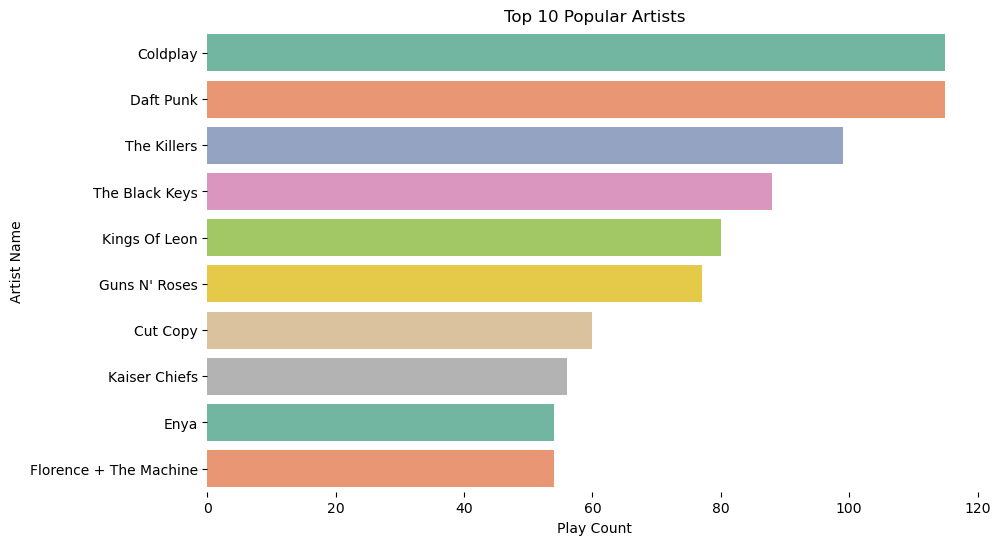

In [16]:
# Group by 'artist_name' and count 'play_count'
ten_pop_artists = df_merged.groupby('artist_name')['play_count'].count().reset_index()
ten_pop_artists = ten_pop_artists.sort_values(['play_count', 'artist_name'], ascending=[False, True]).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='play_count', y='artist_name', data=ten_pop_artists, palette='Set2')
sns.despine(left=True, bottom=True)

plt.xlabel('Play Count')
plt.ylabel('Artist Name')
plt.title('Top 10 Popular Artists')
plt.show()

/var/folders/v_/5zlxwvfs6cv33yj3189fg8km0000gn/T/ipykernel_21741/2210264456.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot (song_user. values, color='orange')


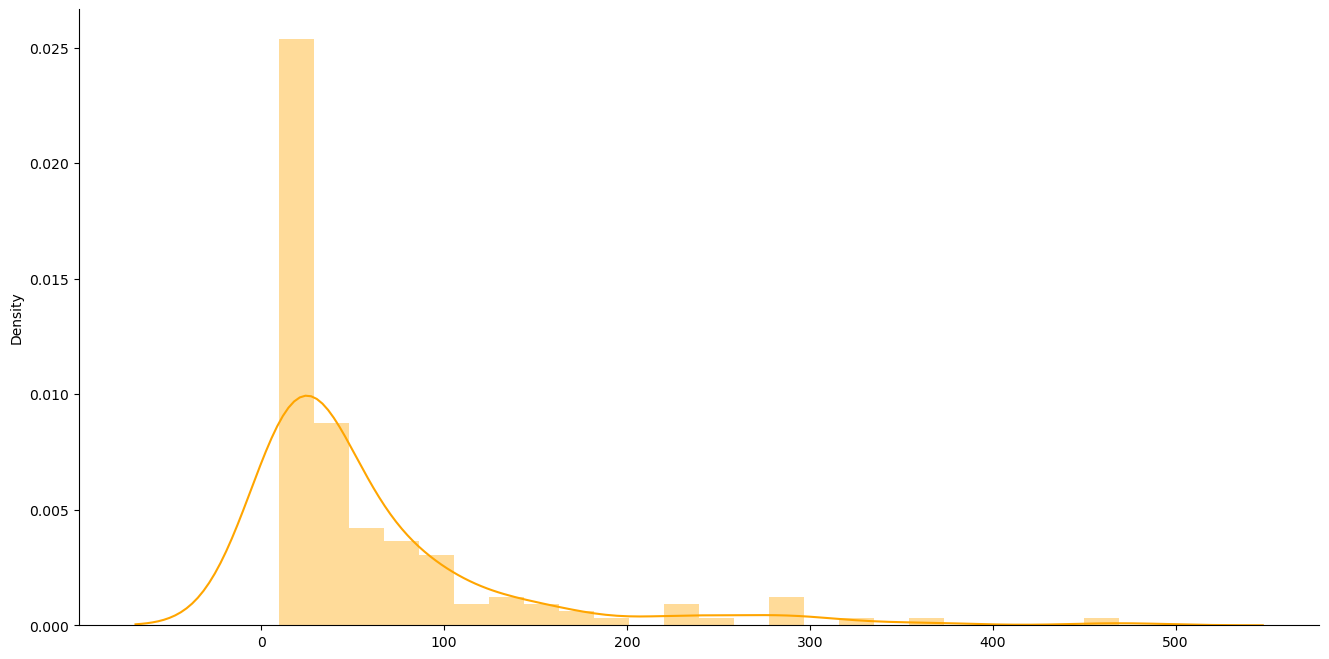

In [17]:
song_user = df_merged.groupby('user')['track_id'].count()
plt.figure(figsize=(16, 8))
sns.distplot (song_user. values, color='orange')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [18]:
#SVD

In [19]:
songs.head()

,user,song,play_count,track_id,artist_name,song_title
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Billy Preston,Nothing from Nothing
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Paco De Lucia,Entre Dos Aguas
3,930d2be6c85315d72cab9823ec0f7bfe7e477794,SOBBMDR12A8C13253B,1,TRMHBXZ128F4238406,Paco De Lucia,Entre Dos Aguas
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Josh Rouse,Under Cold Blue Stars


In [20]:
# Load the dataset into a Surprise Dataset format
reader = Reader(rating_scale=(songs['play_count'].min(), songs['play_count'].max()))
data = Dataset.load_from_df(songs[['user', 'song', 'play_count']], reader)

# Split the data into train and test sets using Surprise's train_test_split
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)


In [21]:
# Define the parameter grid for SVD
param_grid = {'n_factors': [10,30,50],
              'n_epochs': [20,25, 30],
              'lr_all': [0.003, 0.005, 0.01],
              'reg_all': [0.001, 0.02, 0.2]}

# Initialize the SVD algorithm
algo = SVD()

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
grid_search.fit(data)

# Get the best RMSE score and best parameters
print("Best RMSE score:", grid_search.best_score['rmse'])
print("Best parameters:", grid_search.best_params['rmse'])

Best RMSE score: 4.155851365474859
Best parameters: {'n_factors': 30, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.02}


/var/folders/v_/5zlxwvfs6cv33yj3189fg8km0000gn/T/ipykernel_21741/344376972.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_table = pivot_table.pivot('param_n_factors', 'param_n_epochs', 'mean_test_rmse')


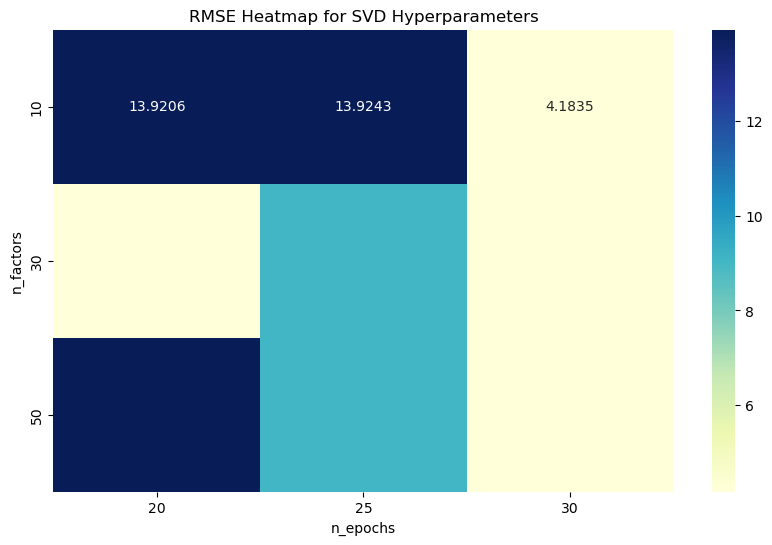

In [22]:
# Get the results as a Pandas DataFrame
results_df = pd.DataFrame.from_dict(grid_search.cv_results)

# Pivot the DataFrame to create visualizations
pivot_table = results_df.pivot_table(values='mean_test_rmse', index=['param_n_factors', 'param_n_epochs'], aggfunc='mean').reset_index()
pivot_table = pivot_table.pivot('param_n_factors', 'param_n_epochs', 'mean_test_rmse')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title('RMSE Heatmap for SVD Hyperparameters')
plt.xlabel('n_epochs')
plt.ylabel('n_factors')
plt.show()

RMSE: 4.9128


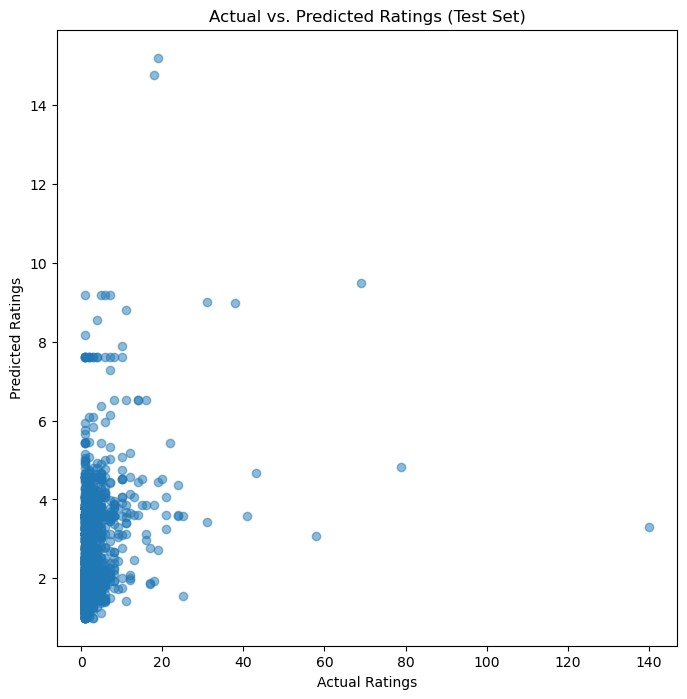

In [23]:
from surprise.model_selection import train_test_split as surprise_train_test_split
 
# Load the dataset into a Surprise Dataset format
reader = Reader(rating_scale=(songs['play_count'].min(), songs['play_count'].max()))
data = Dataset.load_from_df(songs[['user', 'song', 'play_count']], reader)
 
# Split the data into train and test sets using Surprise's train_test_split
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)
 
# Initialize the SVD algorithm
algo = SVD()
 
# Train the algorithm on the trainset
algo.fit(trainset)
 
# Make predictions on the test set
predictions = algo.test(testset)
 
# Calculate RMSE (Root Mean Squared Error) on the test set
accuracy.rmse(predictions)
 
# Extract actual and predicted ratings
actual_ratings = [rating for (_, _, rating) in testset]
predicted_ratings = [pred.est for pred in predictions]
 
# Create a scatter plot of Actual vs. Predicted Ratings
plt.figure(figsize=(8, 8))
plt.scatter(actual_ratings, predicted_ratings, alpha=0.5)
plt.title('Actual vs. Predicted Ratings (Test Set)')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()

In [24]:
#KNN

In [25]:
# Initialize the KNNBasic algorithm
algo = KNNBasic()

# Train the algorithm on the trainset
algo.fit(trainset)

# Make predictions on the test set
predictions = algo.test(testset)

# Calculate RMSE (Root Mean Squared Error) on the test set
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 5.1527


5.152651271444508

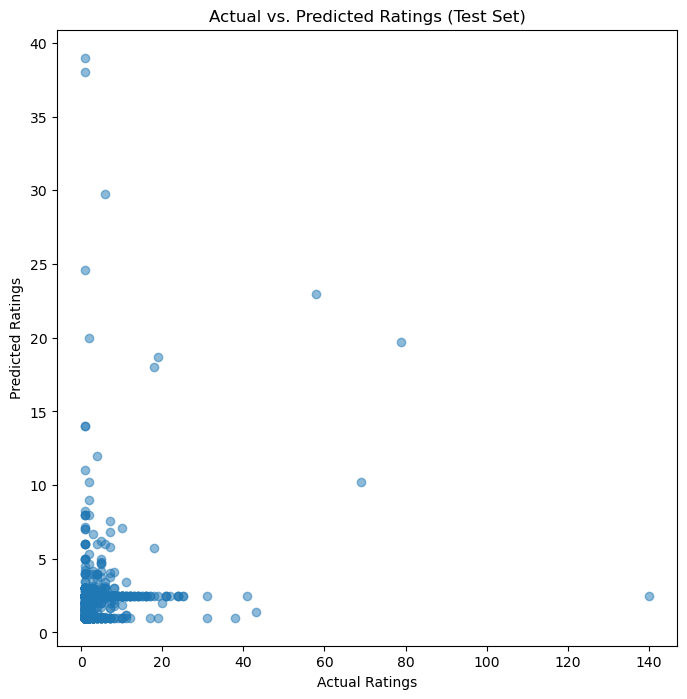

In [26]:
# Extract actual and predicted ratings
actual_ratings = [rating for (_, _, rating) in testset]
predicted_ratings = [pred.est for pred in predictions]

# Create a scatter plot of Actual vs. Predicted Ratings
plt.figure(figsize=(8, 8))
plt.scatter(actual_ratings, predicted_ratings, alpha=0.5)
plt.title('Actual vs. Predicted Ratings (Test Set)')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()

In [27]:
# Define the parameter grid for KNNBasic
param_grid = {'k': [5, 10, 20],
              'min_k': [1, 3, 5],
              'sim_options': {'name': ['cosine', 'msd', 'pearson'],
                              'user_based': [True, False]}}

# Initialize the KNNBasic algorithm
algo = KNNBasic()

# Load the dataset into a Surprise Dataset format
# Assuming 'data' is already defined and loaded correctly

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)
grid_search.fit(data)

# Get the best RMSE score and best parameters
print("Best RMSE score:", grid_search.best_score['rmse'])
print("Best parameters:", grid_search.best_params['rmse'])

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similar

Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity

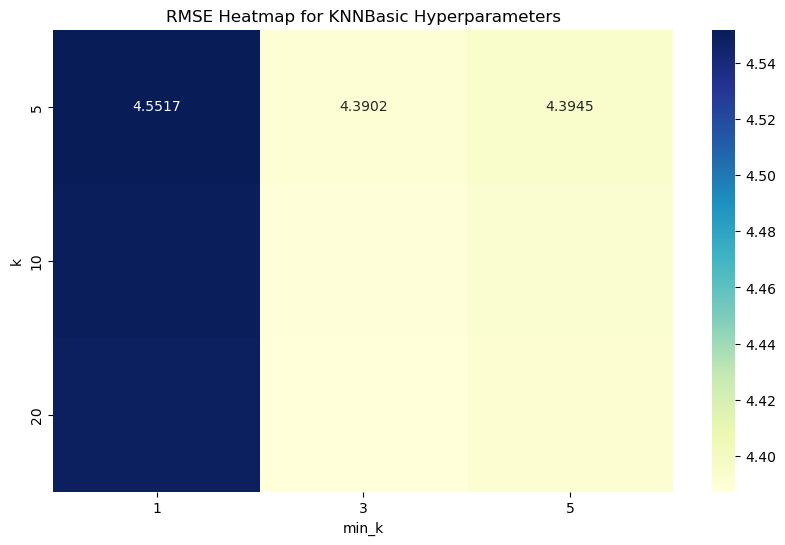

In [28]:
# Get the results as a Pandas DataFrame
results_df = pd.DataFrame.from_dict(grid_search.cv_results)

# Create a heatmap for the parameters
pivot_table = results_df.pivot_table(index='param_k', columns='param_min_k', values='mean_test_rmse')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title('RMSE Heatmap for KNNBasic Hyperparameters')
plt.xlabel('min_k')
plt.ylabel('k')
plt.show()

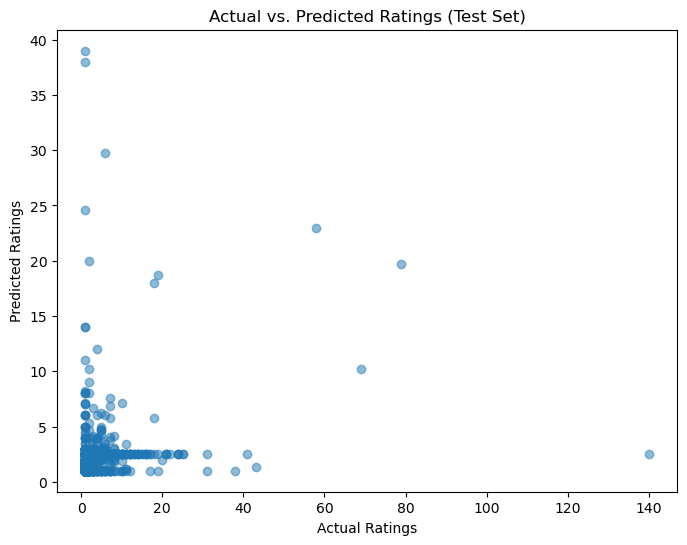

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(actual_ratings, predicted_ratings, alpha=0.5)
plt.title('Actual vs. Predicted Ratings (Test Set)')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.show()

In [30]:
# Content Based Recommendation

**Perform feature extraction**

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_merged['text_features'] = df_merged['user'] + ' ' + df_merged['song']

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
text_matrix = tfidf_vectorizer.fit_transform(df_merged['text_features'])

**Function for content based recommendation**

In [32]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(text_matrix, text_matrix)

def content_based_recommendation(song_index, cosine_sim_matrix, num_recommendations=10):
    similarity_scores = list(enumerate(cosine_sim[song_index]))

    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    recommended_songs = [i for i, _ in similarity_scores[1:num_recommendations + 1]]

    return recommended_songs

**Testing content-based recommendation**

In [33]:
test_song_index = 0 

song = df_merged.iloc[test_song_index]['song_title']

print("\n-------------------------------------- \
      \nContent-Based Recommendation for song at index: {}\n--------------------------------------\n".format(song))
recommended_songs = content_based_recommendation(test_song_index, cosine_sim, num_recommendations=10)

rank_value = 1
for song_index in recommended_songs:
    song_details = df_merged.iloc[song_index][['user', 'song', 'artist_name', 'song_title']]
    print("#{}: {} By {}".format(rank_value, song_details['song_title'], song_details['artist_name']))
    rank_value += 1



--------------------------------------       
Content-Based Recommendation for song at index: The Cove
--------------------------------------

#1: Sehr kosmisch By Harmonia
#2: Stronger By Kanye West
#3: Stronger By Kanye West
#4: Behind The Sea [Live In Chicago] By Panic At The Disco
#5: Learn To Fly By Foo Fighters
#6: The Middle By Jimmy Eat World
#7: Paper Gangsta By Lady GaGa
#8: I?'m A Steady Rollin? Man By Robert Johnson
#9: Champion By Kanye West
#10: Trani By Kings Of Leon


In [34]:
test_song_index = 2

song = df_merged.iloc[test_song_index]['song_title']

print("\n-------------------------------------- \
      \nContent-Based Recommendation for song at index: {}\n--------------------------------------\n".format(song))
recommended_songs = content_based_recommendation(test_song_index, cosine_sim, num_recommendations=10)

rank_value = 1
for song_index in recommended_songs:
    song_details = df_merged.iloc[song_index][['user', 'song', 'artist_name', 'song_title']]
    print("#{}: {} By {}".format(rank_value, song_details['song_title'], song_details['artist_name']))
    rank_value += 1



--------------------------------------       
Content-Based Recommendation for song at index: Entre Dos Aguas
--------------------------------------

#1: Entre Dos Aguas By Paco De Lucia
#2: Sehr kosmisch By Harmonia
#3: Stronger By Kanye West
#4: Stronger By Kanye West
#5: Behind The Sea [Live In Chicago] By Panic At The Disco
#6: Learn To Fly By Foo Fighters
#7: The Middle By Jimmy Eat World
#8: Paper Gangsta By Lady GaGa
#9: I?'m A Steady Rollin? Man By Robert Johnson
#10: Champion By Kanye West
